# **Course:** Introduction to Computer Vision (CS231.Q11)

**Topic:** Face Mask Classification

**Member:** 
- Nguyen Cong Phat - 23521143
- Nguyen Le Phong - 23521168
- Vu Viet Cuong - 23520213 

In [1]:
!pip install optuna

## **1. Imports & config**

In [2]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import seaborn as sns
from tqdm import tqdm
import joblib

In [9]:
DATA_DIR = Path("/kaggle/input/Face Mask Dataset")

SPLITS = ["Train", "Validation", "Test"]
CLASSES = ["WithMask", "WithoutMask"]

IMAGE_SIZE = (128, 128)

# HOG parameters (6x3)
HOG_PARAMS = {
    "orientations": 9,
    "pixels_per_cell": (6, 6),
    "cells_per_block": (3, 3),
    "block_norm": "L2-Hys"
}

# Kaggle only allows writing to /kaggle/working/
CACHE_DIR = Path("/kaggle/working/hog_cache")
CACHE_DIR.mkdir(exist_ok=True, parents=True)

MODELS_DIR = Path("/kaggle/working/models")
MODELS_DIR.mkdir(exist_ok=True, parents=True)

print("DATA_DIR =", DATA_DIR)
print("Cache directory:", CACHE_DIR)
print("Models directory:", MODELS_DIR)

DATA_DIR = /kaggle/input/Face Mask Dataset
Cache directory: /kaggle/working/hog_cache
Models directory: /kaggle/working/models


## **2. Load image paths & basic stats**

In [10]:

def load_split_paths(split: str):
    paths = []
    labels = []
    split_dir = DATA_DIR / split
    for cls in CLASSES:
        class_dir = split_dir / cls
        for img_path in sorted(class_dir.glob("*.*")):
            paths.append(img_path)
            labels.append(cls)
    return np.array(paths), np.array(labels)


all_stats = {}
for split in SPLITS:
    paths, labels = load_split_paths(split)
    unique, counts = np.unique(labels, return_counts=True)
    stats = dict(zip(unique, counts))
    all_stats[split] = stats

all_stats


{'Train': {'WithMask': 5000, 'WithoutMask': 5000},
 'Validation': {'WithMask': 400, 'WithoutMask': 400},
 'Test': {'WithMask': 483, 'WithoutMask': 509}}

## **3. Plot class distribution**

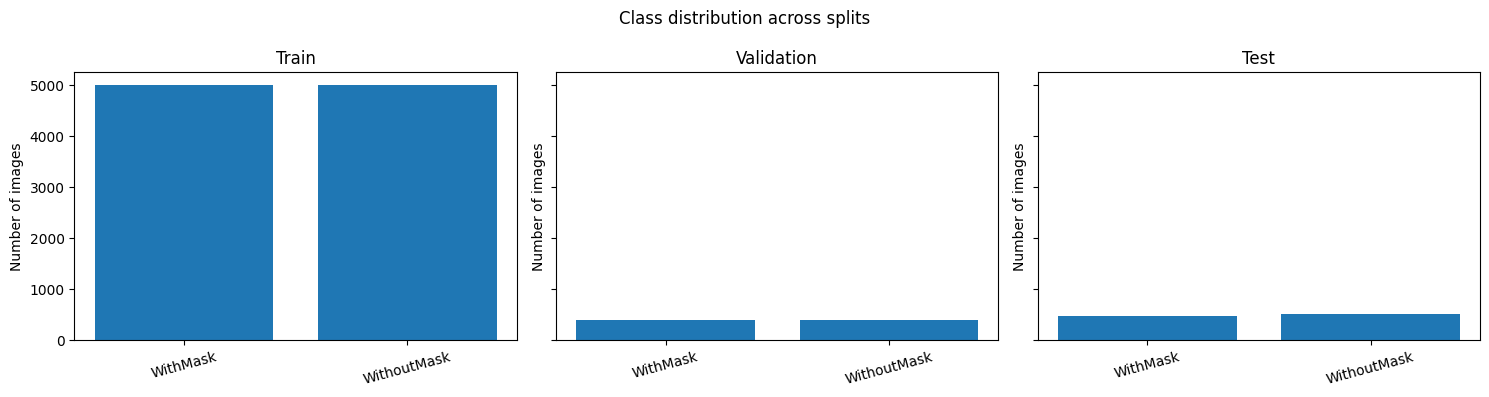

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, split in enumerate(SPLITS):
    stats = all_stats[split]
    ax = axes[i]
    
    ax.bar(range(len(stats)), stats.values())
    ax.set_title(split)
    ax.set_ylabel("Number of images")
    ax.set_xticks(range(len(stats)))
    ax.set_xticklabels(stats.keys(), rotation=15)

plt.suptitle("Class distribution across splits")
plt.tight_layout()
plt.show()

## **4. Show some sample images**

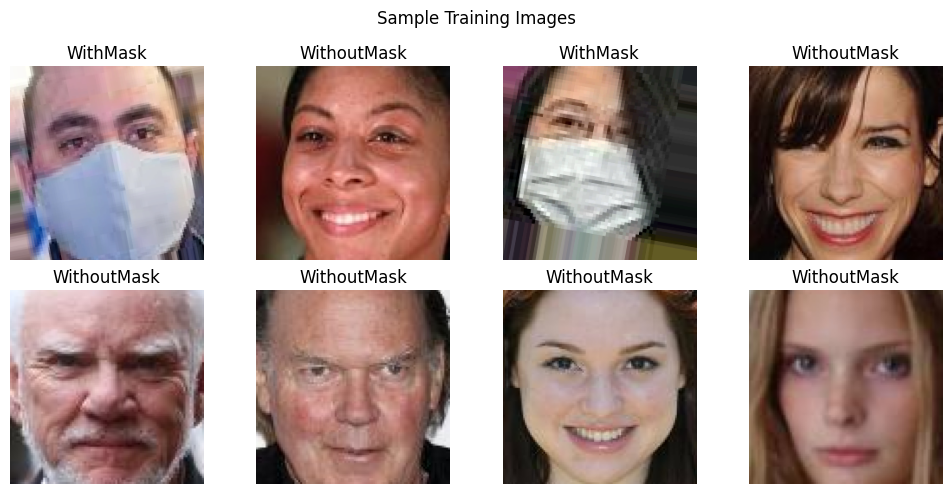

In [14]:
paths_train, labels_train = load_split_paths("Train")

plt.figure(figsize=(10, 5))
idxs = np.random.choice(len(paths_train), size=8, replace=False)
for i, idx in enumerate(idxs, 1):
    img = imread(paths_train[idx])
    plt.subplot(2, 4, i)
    if img.ndim == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.axis("off")
    plt.title(labels_train[idx])

plt.suptitle("Sample Training Images")
plt.tight_layout()
plt.show()


## **5. HOG feature extractor + visualize HOG for 1 image**

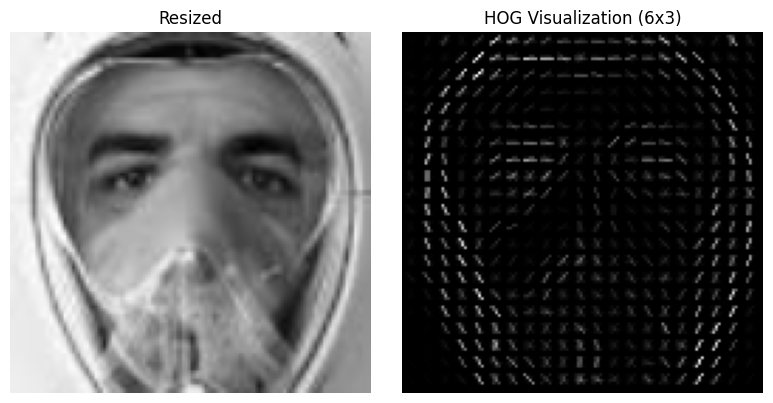

HOG feature length: 29241


In [16]:
def extract_hog_feature(img_path: Path, hog_params: dict) -> np.ndarray:
    img = imread(img_path)
    if img.ndim == 3:
        img_gray = rgb2gray(img)
    else:
        img_gray = img

    img_resized = resize(img_gray, IMAGE_SIZE, anti_aliasing=True)
    feat = hog(img_resized, **hog_params)
    return feat


# visualize HOG
from skimage.feature import hog as hog_vis

sample_img_path = paths_train[0]
sample_img = imread(sample_img_path)
sample_gray = rgb2gray(sample_img) if sample_img.ndim == 3 else sample_img
sample_resized = resize(sample_gray, IMAGE_SIZE, anti_aliasing=True)

hog_feats, hog_image = hog_vis(sample_resized, visualize=True, **HOG_PARAMS)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_resized, cmap="gray")
plt.title("Resized")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap="gray")
plt.title("HOG Visualization (6x3)")
plt.axis("off")

plt.tight_layout()
plt.show()

print("HOG feature length:", hog_feats.size)

## **6. Build & cache HOG features**

In [17]:
def get_hog_features(split: str):
    cache_file = CACHE_DIR / f"HOG_6x3_{split}.npz"

    if cache_file.exists():
        data = np.load(cache_file)
        print(f"[{split}] Loaded from cache")
        return data["X"], data["y"]

    print(f"[{split}] Extracting HOG features...")
    paths, labels = load_split_paths(split)

    feats = []
    for p in tqdm(paths):
        feats.append(extract_hog_feature(p, HOG_PARAMS))

    X = np.vstack(feats)
    y = labels
    np.savez_compressed(cache_file, X=X, y=y)
    print(f"[{split}] Saved to cache")
    return X, y


X_train, y_train = get_hog_features("Train")
X_val,   y_val   = get_hog_features("Validation")
X_test,  y_test  = get_hog_features("Test")

X_train.shape, X_val.shape, X_test.shape

[Train] Extracting HOG features...


100%|██████████| 10000/10000 [04:02<00:00, 41.16it/s]


[Train] Saved to cache
[Validation] Extracting HOG features...


100%|██████████| 800/800 [00:23<00:00, 34.77it/s]


[Validation] Saved to cache
[Test] Extracting HOG features...


100%|██████████| 992/992 [00:28<00:00, 34.75it/s]


[Test] Saved to cache


((10000, 29241), (800, 29241), (992, 29241))

## **7. Encode labels**

In [18]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

le.classes_, np.bincount(y_train_enc)

(array(['WithMask', 'WithoutMask'], dtype='<U11'), array([5000, 5000]))

## **8. Optuna + SVM (HOG 6x3)**

In [19]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from sklearn.svm import SVC

def objective(trial):
    params = {
        "C": trial.suggest_float("C", 1e-2, 1e2, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "rbf"]),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "probability": False, # tắt probability để speed-up
        "random_state": 42,
    }

    clf = SVC(**params)
    clf.fit(X_train, y_train_enc)
    pred = clf.predict(X_val)
    return accuracy_score(y_val_enc, pred)


study = optuna.create_study(
    direction="maximize",
    pruner=MedianPruner(n_startup_trials=5),
    sampler=TPESampler(multivariate=True),
)

study.optimize(objective, n_trials=30, n_jobs=1)

print("Best validation accuracy:", study.best_value)
print("Best params:", study.best_params)

/usr/local/lib/python3.11/dist-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-29 09:39:27,136] A new study created in memory with name: no-name-ea9c9db8-89a5-40bf-9998-729388688d3a
[I 2025-11-29 09:48:10,896] Trial 0 finished with value: 0.99 and parameters: {'C': 35.10517274707538, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.99.
[I 2025-11-29 09:51:44,202] Trial 1 finished with value: 0.99 and parameters: {'C': 7.844594030933162, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.99.
[I 2025-11-29 09:55:17,768] Trial 2 finished with value: 0.99 and parameters: {'C': 0.036329184666463926, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.99.
[I 2025-11-29 10:19:58,865] Trial 3 finished with value: 0.965 and parameters: {'C': 0.5145388809831426, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 wi

Best validation accuracy: 0.99125
Best params: {'C': 0.9268228670485432, 'kernel': 'rbf', 'gamma': 'scale'}


## **9. Refit with best params**

In [20]:
best_params = study.best_params.copy()
best_params["probability"] = False
best_params["random_state"] = 42

X_combined = np.vstack([X_train, X_val])
y_combined = np.concatenate([y_train_enc, y_val_enc])

best_svm = SVC(**best_params)
best_svm.fit(X_combined, y_combined)

print("Done training final SVM.")
best_params

Done training final SVM.


{'C': 0.9268228670485432,
 'kernel': 'rbf',
 'gamma': 'scale',
 'probability': False,
 'random_state': 42}

## **10. Evaluate on Test + confusion matrix + save model**

Test Accuracy: 0.9879

Classification Report:
              precision    recall  f1-score   support

    WithMask       0.98      1.00      0.99       483
 WithoutMask       1.00      0.98      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



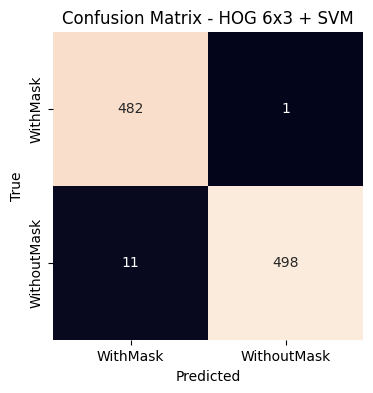

Model saved to: /kaggle/working/models/HOG_6x3_SVM_Optuna.joblib


In [21]:
y_pred = best_svm.predict(X_test)

acc = accuracy_score(y_test_enc, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - HOG 6x3 + SVM")
plt.show()

# Save model
model_path = MODELS_DIR / "HOG_6x3_SVM_Optuna.joblib"
joblib.dump({
    "model": best_svm,
    "label_encoder": le,
    "hog_params": HOG_PARAMS,
    "image_size": IMAGE_SIZE,
}, model_path)

print("Model saved to:", model_path)